In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from pandas import DataFrame,Series

#导入数据
df=pd.read_csv(r'data.csv',encoding='gbk')

In [2]:
df.select_dtypes(include=['object']).head()

,trade_no,bank_card_no,reg_preference_for_trad,source,id_name,latest_query_time,loans_latest_time
0,20180507115231274000000023057383,卡号1,一线城市,xs,蒋红,2018-04-25,2018-04-19
1,20180507121002192000000023073000,卡号1,一线城市,xs,崔向朝,2018-05-03,2018-05-05
2,20180507125159718000000023114911,卡号1,一线城市,xs,王中云,2018-05-05,2018-05-01
3,20180507121358683000000388283484,卡号1,三线城市,xs,何洋洋,2018-05-05,2018-05-03
4,20180507115448545000000388205844,卡号1,一线城市,xs,赵洋,2018-04-15,2018-01-07


0    3561
1    1193
Name: status, dtype: int64


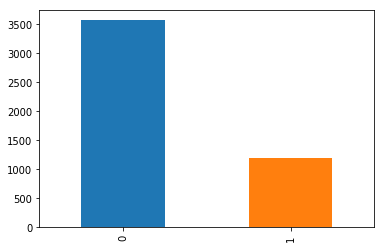

In [3]:
#查看标签列 status的分布均衡性(处理前).plot可以简单看一下分布，柱状图
print(df['status'].value_counts())
df['status'].value_counts().plot(kind='bar')

坏客户1193个，好客户3561个，约为1:3

In [4]:
#计算缺失率和唯一率：删除一些不必要的列
df_1=pd.DataFrame(df.isnull().sum(),columns=['loss_num'])
df_2=pd.DataFrame(df.nunique(),columns=['unique_num'])
df_loss_unique=pd.merge(df_1,df_2,right_index=True,left_index=True)
df_loss_unique['loss_rate']=round(df_loss_unique['loss_num']/df.shape[0],2)
df_loss_unique['unique_rate']=round(df_loss_unique['unique_num']/df.shape[0],2)

df_loss_unique.head()

,loss_num,unique_num,loss_rate,unique_rate
Unnamed: 0,0,4754,0.0,1.00
custid,0,4754,0.0,1.00
trade_no,0,4754,0.0,1.00
bank_card_no,0,1,0.0,0.00
low_volume_percent,2,40,0.0,0.01


In [5]:
#查看缺失比较多的列
df_loss_unique.sort_values(by='loss_rate',ascending=False).head()

,loss_num,unique_num,loss_rate,unique_rate
student_feature,2998,2,0.63,0.00
cross_consume_count_last_1_month,426,19,0.09,0.00
loans_latest_day,297,235,0.06,0.05
latest_one_month_loan,297,14,0.06,0.00
consfin_org_count_behavior,297,19,0.06,0.00


In [6]:
#查看唯一值情况 唯一率特别高或者特别低的都可以考虑删除
df_loss_unique.sort_values(by='unique_rate',ascending=False).head()

,loss_num,unique_num,loss_rate,unique_rate
Unnamed: 0,0,4754,0.00,1.00
trade_no,0,4754,0.00,1.00
custid,0,4754,0.00,1.00
historical_trans_amount,0,4524,0.00,0.95
id_name,276,4309,0.06,0.91


In [7]:
#综合上面两张表，可以得出：student_feature缺失严重，删掉；num、custid、id_name唯一率较高，无意义，可删掉；
#bank_card_no、trade_no、source唯一率极低，且无意义，删掉
#在发现缺失率或者唯一率较高的变量后，需要结合业务实际，有一些明显有意义的变量不能删除，应该考虑填充缺失值
columns_drop=['student_feature','bank_card_no','source','trade_no','id_name','custid']
df.drop(columns=columns_drop,axis=1,inplace=True)

In [8]:
#查看数据大小
df.shape

(4754, 84)

In [9]:
#处理latest_query_time、loans_latest_time，这两个日期与当前时间的差值是有意义的

#计算两个日期与今天的差值，单位是天，后续可以标准化处理，也可以计算这两个日期的差值

#日期处理为日期格式datetime，并生成新的一列 loans_time
df['latest_query_time']=pd.to_datetime(df['latest_query_time'])
df['loans_latest_time']=pd.to_datetime(df['loans_latest_time'])

#将timedelta格式转化为float类型(秒)
df['loans_time']=df['loans_latest_time']-df['latest_query_time']
df['loans_time']=df['loans_time'].dt.total_seconds().dropna()

#两列日期格式数据处理直接丢弃
datatime_data=['loans_latest_time','latest_query_time']
df.drop(datatime_data,axis=1,inplace=True)

#将城市进行数值化
map_dict={'一线城市':1,'二线城市':2,'三线城市':3,'境外':4,'其他':0}
df['reg_preference_for_trad']=df['reg_preference_for_trad'].map(map_dict)

In [10]:
df.head()

,Unnamed: 0,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,...,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day,loans_time
0,5,0.01,0.99,0,0.90,0.55,0.313,17.0,27.0,26.0,...,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0,-518400.0
1,10,0.02,0.94,2000,1.28,1.00,0.458,19.0,30.0,14.0,...,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0,172800.0
2,12,0.04,0.96,0,1.00,1.00,0.114,13.0,68.0,22.0,...,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0,-345600.0
3,13,0.00,0.96,2000,0.13,0.57,0.777,22.0,14.0,6.0,...,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0,-172800.0
4,14,0.01,0.99,0,0.46,1.00,0.175,13.0,66.0,42.0,...,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0,-8467200.0


In [11]:
#统计缺失值
df.isnull().sum()

Unnamed: 0                                 0
low_volume_percent                         2
middle_volume_percent                      2
take_amount_in_later_12_month_highest      0
trans_amount_increase_rate_lately          3
trans_activity_month                       2
trans_activity_day                         2
transd_mcc                                 2
trans_days_interval_filter                 8
trans_days_interval                        2
regional_mobility                          2
repayment_capability                       0
is_high_user                               0
number_of_trans_from_2011                  2
first_transaction_time                     2
historical_trans_amount                    0
historical_trans_day                       2
rank_trad_1_month                          2
trans_amount_3_month                       0
avg_consume_less_12_valid_month            2
abs                                        0
top_trans_count_last_1_month               2
avg_price_

In [12]:
#动作1：数量较小，直接丢弃
# df.dropna(inplace=True)

#动作2：缺失值以中位值进行填充
#运用Imputer模块进行填充
#missing_values：需要被填充的缺失值，strategy：填充的方式，median，mean，most_frequent
from sklearn.preprocessing import Imputer
columns=list(df)
imp=Imputer(missing_values=np.nan,strategy='median')
df=imp.fit_transform(df)
print('number after processing:',df.shape)
df=pd.DataFrame(df,columns=columns)

#再次统计缺失值
print('缺失值:','\n',(df.isnull().sum()))
df.head()

number after processing: (4754, 83)
缺失值: 
 Unnamed: 0                               0
low_volume_percent                       0
middle_volume_percent                    0
take_amount_in_later_12_month_highest    0
trans_amount_increase_rate_lately        0
trans_activity_month                     0
trans_activity_day                       0
transd_mcc                               0
trans_days_interval_filter               0
trans_days_interval                      0
regional_mobility                        0
repayment_capability                     0
is_high_user                             0
number_of_trans_from_2011                0
first_transaction_time                   0
historical_trans_amount                  0
historical_trans_day                     0
rank_trad_1_month                        0
trans_amount_3_month                     0
avg_consume_less_12_valid_month          0
abs                                      0
top_trans_count_last_1_month             0
avg_price_l

,Unnamed: 0,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,...,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day,loans_time
0,5.0,0.01,0.99,0.0,0.90,0.55,0.313,17.0,27.0,26.0,...,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0,-518400.0
1,10.0,0.02,0.94,2000.0,1.28,1.00,0.458,19.0,30.0,14.0,...,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0,172800.0
2,12.0,0.04,0.96,0.0,1.00,1.00,0.114,13.0,68.0,22.0,...,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0,-345600.0
3,13.0,0.00,0.96,2000.0,0.13,0.57,0.777,22.0,14.0,6.0,...,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0,-172800.0
4,14.0,0.01,0.99,0.0,0.46,1.00,0.175,13.0,66.0,42.0,...,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0,-8467200.0


In [13]:
#丢掉方差为0的列，代表没有任何波动
df.drop(df.columns[df.std()==0],axis=1,inplace=True)

In [14]:
df.shape

(4754, 83)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 83 columns):
Unnamed: 0                                    4754 non-null float64
low_volume_percent                            4754 non-null float64
middle_volume_percent                         4754 non-null float64
take_amount_in_later_12_month_highest         4754 non-null float64
trans_amount_increase_rate_lately             4754 non-null float64
trans_activity_month                          4754 non-null float64
trans_activity_day                            4754 non-null float64
transd_mcc                                    4754 non-null float64
trans_days_interval_filter                    4754 non-null float64
trans_days_interval                           4754 non-null float64
regional_mobility                             4754 non-null float64
repayment_capability                          4754 non-null float64
is_high_user                                  4754 non-null float64
number_of

# 使用相关系数>0.05

In [16]:
#换种方式考察各列和目标列之间的相关性

#计算每列和另外所有列的相关系数
cor=df.corr()

#获取每一列和‘status’的相关系数，这是我们的目标
corr=np.abs(cor['status'].sort_values(ascending=False)).to_frame(name='corelation').reset_index()
print(type(np.abs(cor['status'].sort_values(ascending=False))))
#选取特征大于0.05的列进行保留
deleted_corr_columns=list(corr[corr.corelation<0.05]['index'])
print(deleted_corr_columns)
df.drop(deleted_corr_columns,inplace=True,axis=1)

<class 'pandas.core.series.Series'>
['loans_count', 'middle_volume_percent', 'first_transaction_time', 'consfin_product_count', 'consfin_org_count_current', 'consfin_org_count_behavior', 'loans_org_count_behavior', 'railway_consume_count_last_12_month', 'loans_product_count', 'consume_top_time_last_6_month', 'loans_latest_day', 'loans_cash_count', 'loans_org_count_current', 'query_sum_count', 'Unnamed: 0', 'trans_top_time_last_6_month', 'query_org_count', 'max_consume_count_later_6_month', 'trans_days_interval', 'trans_activity_month', 'loans_long_time', 'loans_time', 'reg_preference_for_trad', 'loans_credibility_limit', 'latest_six_month_apply', 'query_finance_count', 'transd_mcc', 'take_amount_in_later_12_month_highest', 'loans_credibility_behavior', 'jewelry_consume_count_last_6_month', 'trans_days_interval_filter', 'trans_amount_increase_rate_lately', 'repayment_capability', 'abs', 'cross_consume_count_last_1_month', 'latest_three_month_apply', 'loans_avg_limit', 'consume_mini_time

In [17]:
df.shape

(4754, 25)

In [18]:
df=pd.read_csv(r'data.csv',encoding='gbk')

columns_drop=['student_feature','bank_card_no','source','trade_no','id_name','custid']
df.drop(columns=columns_drop,axis=1,inplace=True)

df['latest_query_time']=pd.to_datetime(df['latest_query_time'])
df['loans_latest_time']=pd.to_datetime(df['loans_latest_time'])

#将timedelta格式转化为float类型(秒)
df['loans_time']=df['loans_latest_time']-df['latest_query_time']
df['loans_time']=df['loans_time'].dt.total_seconds().dropna()

#两列日期格式数据处理直接丢弃
datatime_data=['loans_latest_time','latest_query_time']
df.drop(datatime_data,axis=1,inplace=True)

#将城市进行数值化
map_dict={'一线城市':1,'二线城市':2,'三线城市':3,'境外':4,'其他':0}
df['reg_preference_for_trad']=df['reg_preference_for_trad'].map(map_dict)

from sklearn.preprocessing import Imputer
columns=list(df)
imp=Imputer(missing_values=np.nan,strategy='median')
df=imp.fit_transform(df)
print('number after processing:',df.shape)
df=pd.DataFrame(df,columns=columns)

#再次统计缺失值
print('缺失值:','\n',(df.isnull().sum()))
df.head()

number after processing: (4754, 83)
缺失值: 
 Unnamed: 0                               0
low_volume_percent                       0
middle_volume_percent                    0
take_amount_in_later_12_month_highest    0
trans_amount_increase_rate_lately        0
trans_activity_month                     0
trans_activity_day                       0
transd_mcc                               0
trans_days_interval_filter               0
trans_days_interval                      0
regional_mobility                        0
repayment_capability                     0
is_high_user                             0
number_of_trans_from_2011                0
first_transaction_time                   0
historical_trans_amount                  0
historical_trans_day                     0
rank_trad_1_month                        0
trans_amount_3_month                     0
avg_consume_less_12_valid_month          0
abs                                      0
top_trans_count_last_1_month             0
avg_price_l

,Unnamed: 0,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,...,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day,loans_time
0,5.0,0.01,0.99,0.0,0.90,0.55,0.313,17.0,27.0,26.0,...,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0,-518400.0
1,10.0,0.02,0.94,2000.0,1.28,1.00,0.458,19.0,30.0,14.0,...,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0,172800.0
2,12.0,0.04,0.96,0.0,1.00,1.00,0.114,13.0,68.0,22.0,...,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0,-345600.0
3,13.0,0.00,0.96,2000.0,0.13,0.57,0.777,22.0,14.0,6.0,...,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0,-172800.0
4,14.0,0.01,0.99,0.0,0.46,1.00,0.175,13.0,66.0,42.0,...,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0,-8467200.0


In [19]:
df.shape

(4754, 83)

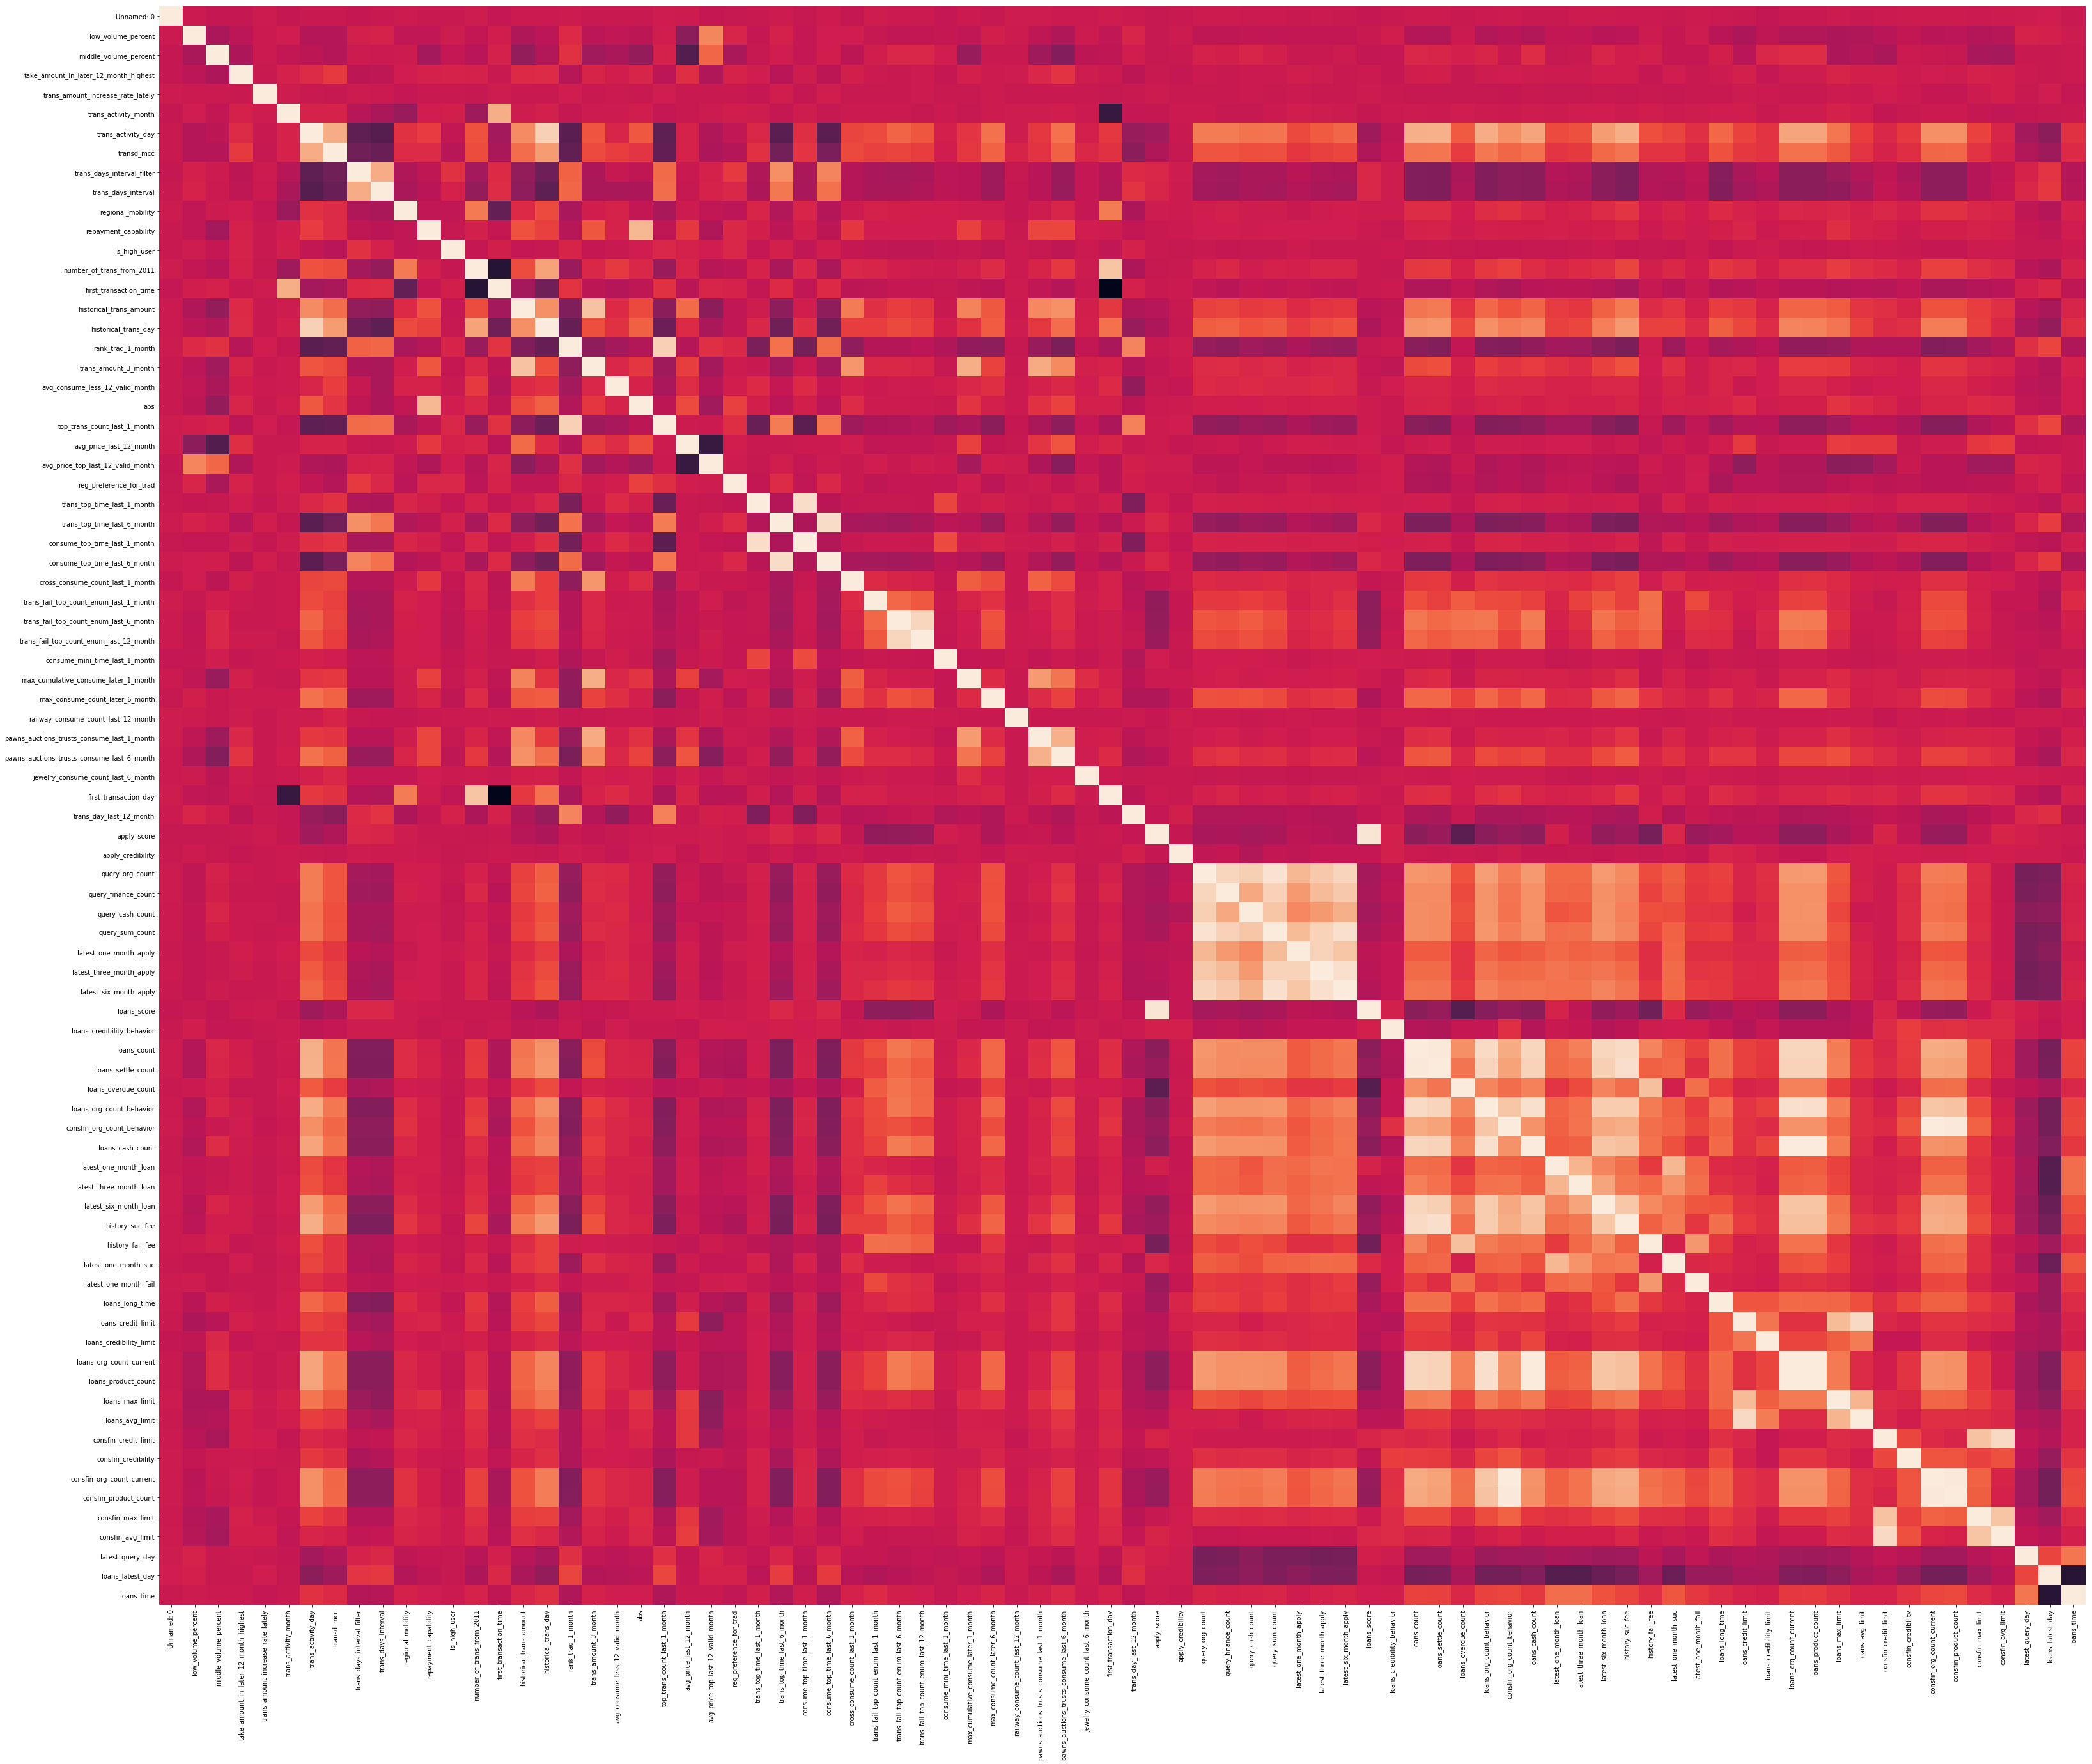

In [20]:
#热力图研究相关性,各个变量之间的相关性，相关性较高的变量可以考虑合并筛选
plt.figure(figsize=(54,46))
corr=df.drop(['status'],axis=1).corr()
#注意给lables值设置大小和格式,不然显示不清
#show 列表名
#print(list(df))
#print(df.shape)
sns.heatmap(corr,fmt='.2f',annot=False,cbar=False,annot_kws={'size':24,'weight':'bold'})

将相关系数超过0.9的进行筛选，只保留一列，一般情况下会合并成新变量，不应直接删除

In [21]:
#区分X和Y
train_x=df.drop(['status'],axis=1)
train_y=pd.DataFrame(df['status'])

print(train_x.shape)
print(train_y.shape)
train_x.head()

(4754, 82)
(4754, 1)


,Unnamed: 0,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,...,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day,loans_time
0,5.0,0.01,0.99,0.0,0.90,0.55,0.313,17.0,27.0,26.0,...,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0,-518400.0
1,10.0,0.02,0.94,2000.0,1.28,1.00,0.458,19.0,30.0,14.0,...,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0,172800.0
2,12.0,0.04,0.96,0.0,1.00,1.00,0.114,13.0,68.0,22.0,...,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0,-345600.0
3,13.0,0.00,0.96,2000.0,0.13,0.57,0.777,22.0,14.0,6.0,...,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0,-172800.0
4,14.0,0.01,0.99,0.0,0.46,1.00,0.175,13.0,66.0,42.0,...,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0,-8467200.0


In [22]:
#拆分测试集和训练集
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(train_x,train_y,test_size=0.3,random_state=2018)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3327, 82)
(1427, 82)
(3327, 1)
(1427, 1)


In [23]:
#引入模型进行训练
from sklearn.neighbors import KNeighborsClassifier#KNN算法
from sklearn.ensemble import RandomForestClassifier#随机森林
from sklearn.metrics import precision_score#精度
from sklearn.metrics import recall_score#召回率
from sklearn.metrics import accuracy_score#准确率
from sklearn.metrics import roc_auc_score#roc曲线下积分面积

In [24]:
'''
#定义计算iv值的函数
def calc_iv(df, feature, target, pr=False):
    """
    Set pr=True to enable printing of output.

    Output:
      * iv: float,
      * data: pandas.DataFrame
    """
    lst = []
    df[feature] = df[feature].fillna('NULL')

    for i in range(df[feature].nunique()):  # nuinque()是查看该序列(axis=0/1对应着列或行)的不同值的数量个数
        val = list(df[feature].unique())[i]
        lst.append([feature,
                    val,  # Value
                    df[df[feature] == val].count()[feature],  # all
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # good rate
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]])  # bad rate
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print("IV = ", data['IV'].sum())

    iv = data['IV'].sum()

    return iv, data

column_headers = list(df.columns.values)
# print(column_headers)

d=[]
for x in column_headers:
    IV_1, data = calc_iv(df, x, 'status')
    d.append(IV_1)
#整理成Series类型并合并
column_headers=pd.Series(column_headers,name='feature')
d=pd.Series(d,name='iv_value')

# print(column_headers)
iv_result=pd.concat([column_headers,d],axis=1)
iv_result.sort_values(by='iv_value',ascending=False)

#     print('{}： {}'.format(x, IV_1))
'''

'\n#定义计算iv值的函数\ndef calc_iv(df, feature, target, pr=False):\n    """\n    Set pr=True to enable printing of output.\n\n    Output:\n      * iv: float,\n      * data: pandas.DataFrame\n    """\n    lst = []\n    df[feature] = df[feature].fillna(\'NULL\')\n\n    for i in range(df[feature].nunique()):  # nuinque()是查看该序列(axis=0/1对应着列或行)的不同值的数量个数\n        val = list(df[feature].unique())[i]\n        lst.append([feature,\n                    val,  # Value\n                    df[df[feature] == val].count()[feature],  # all\n                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # good rate\n                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]])  # bad rate\n    data = pd.DataFrame(lst, columns=[\'Variable\', \'Value\', \'All\', \'Good\', \'Bad\'])\n\n    data[\'Share\'] = data[\'All\'] / data[\'All\'].sum()\n    data[\'Bad Rate\'] = data[\'Bad\'] / data[\'All\']\n    data[\'Distribution Good\'] = (data[\'All\'] - data[\'Bad\']) / (dat

In [25]:
#计算离散型变量的iv值reg_preference_for_trad
def calc_iv_obj(y,x):
    df=pd.DataFrame({'X':x,'Y':y})
    
    df.dropna(inplace=True)
    
    total_bad=df[df['Y']==1].shape[0]
    
    total_good=df[df['Y']==0].shape[0]
    
    df_group_bad=df.groupby(['X']).Y.sum().reset_index()
    
    df_group_bad.columns=['X_1','group_bad']
    
    df_group_total=df.groupby(['X']).Y.count().reset_index()
    
    df_group_total.columns=['X_2','group_total']
    
    df_merge=pd.merge(df_group_bad,df_group_total,how='left',left_on=['X_1'],right_on=['X_2'])
    
    df_merge['group_good']=df_merge['group_total']-df_merge['group_bad']
    
    df_merge['woe']=np.log((df_merge['group_bad']/total_bad)/(df_merge['group_good']/total_good))
    
    df_merge['iv']=((df_merge['group_bad']/total_bad)/(df_merge['group_good']/total_good))*df_merge['woe']
    
    return np.sum(df_merge['iv'].values)

In [26]:
import scipy.stats.stats as stats

In [27]:
#计算连续变量的iv值，需要分箱，等频分箱
def calc_iv_num(Y,X,n=10):
    X2=X.fillna(np.median(X))
    r=0
    while np.abs(r)<1:
        d1=pd.DataFrame({'X':X2,'Y':Y,'bucket':pd.qcut(X,n,duplicates='drop')})
        d2=d1.groupby('bucket',as_index=True)
        
        r,p=stats.spearmanr(d2.X.mean(),d2.Y.mean())
        n=n-1
        
    total_good=d1[d1['Y']==0].shape[0]
    total_bad=d1[d1['Y']==1].shape[0]
    df_group_bad=d1.groupby(['bucket']).Y.sum().reset_index()
    df_group_bad.columns=['bucket','bad']
    df_group_total=d1.groupby(['bucket']).Y.count().reset_index()
    df_group_total.columns=['bucket','total']
    df_merge=pd.merge(df_group_bad,df_group_total,how='left',left_on=['bucket'],right_on=['bucket'])
    df_merge['good']=df_merge['total']-df_merge['bad']
    df_merge['woe']=np.log((df_merge['bad']/total_bad)/(df_merge['good']/total_good))
    
    df_merge['iv']=((df_merge['bad']/total_bad)/(df_merge['good']/total_good))*df_merge['woe']
    
    return np.sum(df_merge['iv'].values)

In [28]:
calc_iv_obj(df['status'],df['reg_preference_for_trad'])

0.11968703879824732

In [29]:
#筛选数值型变量
data_num=df.select_dtypes(['int64','float64'])

#生成iv值dataframe
lst=[]
for i in data_num.columns:
    iv=calc_iv_num(data_num['status'],df[i],n=5)
    if iv>1000:
        iv=30
    lst.append(iv)
iv_df=pd.DataFrame(lst,index=data_num.columns,columns=['iv'])
iv_df.sort_values(by='iv',ascending=False)

,iv
trans_fail_top_count_enum_last_1_month,6.232330
loans_overdue_count,3.041027
history_fail_fee,1.789936
loans_score,1.251963
apply_score,1.049326
trans_fail_top_count_enum_last_6_month,0.930232
trans_day_last_12_month,0.643048
top_trans_count_last_1_month,0.565959
trans_fail_top_count_enum_last_12_month,0.526633
rank_trad_1_month,0.445706


In [30]:
#筛选iv值大于0.06的变量
iv_df_final=iv_df[iv_df['iv']>0.06].sort_values(by='iv',ascending=False)
iv_df_final

,iv
trans_fail_top_count_enum_last_1_month,6.232330
loans_overdue_count,3.041027
history_fail_fee,1.789936
loans_score,1.251963
apply_score,1.049326
trans_fail_top_count_enum_last_6_month,0.930232
trans_day_last_12_month,0.643048
top_trans_count_last_1_month,0.565959
trans_fail_top_count_enum_last_12_month,0.526633
rank_trad_1_month,0.445706


In [31]:
col_retain_by_iv=list(iv_df_final.index)

In [32]:
x_train=x_train[col_retain_by_iv]
x_test=x_test[col_retain_by_iv]

In [33]:
x_train.shape

(3327, 24)

In [34]:
x_test.shape

(1427, 24)

In [35]:
# 此时选择将x_train进行标准化
from sklearn.preprocessing import StandardScaler
columns=list(x_train)
x_train=StandardScaler().fit_transform(x_train)
x_train=pd.DataFrame(x_train,columns=columns)

x_test=StandardScaler().fit_transform(x_test)
x_test=pd.DataFrame(x_test,columns=columns)

In [36]:
#定义返回y_pred和y_pred_proba的函数，并能打印训练集和测试集的精度以及ROC曲线面积
#predict返回预测的标签
#predict_proba返回预测标签的概率
def model_metrics(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train,y_train)
    # 预测
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    y_train_proba = clf.predict_proba(X_train)[:,1]
    y_test_proba = clf.predict_proba(X_test)[:,1]
    
    # 准确率
    print('[准确率]', end = ' ')
    print('训练集：', '%.4f'%accuracy_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%accuracy_score(y_test, y_test_pred))
    
    # auc取值：用roc_auc_score或auc
    print('[auc值]', end = ' ')
    print('训练集：', '%.4f'%roc_auc_score(y_train, y_train_proba), end = ' ')
    print('测试集：', '%.4f'%roc_auc_score(y_test, y_test_proba))
    
    #加上return方便后续计算混淆矩阵效果
    return y_test_proba,y_test_pred

In [37]:
rf=RandomForestClassifier()

model_metrics(rf,x_train,x_test,y_train,y_test)

[准确率] 训练集： 0.9802 测试集： 0.7596
[auc值] 训练集： 0.9993 测试集： 0.7095


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(array([0.2, 0. , 0.6, ..., 0.2, 0.4, 0.5]),
 array([0., 0., 1., ..., 0., 0., 0.]))

In [38]:
x_train.shape

(3327, 24)

In [39]:
x_train.columns

Index(['trans_fail_top_count_enum_last_1_month', 'loans_overdue_count',
       'history_fail_fee', 'loans_score', 'apply_score',
       'trans_fail_top_count_enum_last_6_month', 'trans_day_last_12_month',
       'top_trans_count_last_1_month',
       'trans_fail_top_count_enum_last_12_month', 'rank_trad_1_month',
       'max_cumulative_consume_later_1_month', 'low_volume_percent',
       'latest_query_day', 'query_cash_count', 'trans_amount_3_month',
       'consfin_avg_limit', 'latest_six_month_loan', 'consfin_product_count',
       'consfin_org_count_behavior', 'consfin_org_count_current',
       'consfin_credit_limit', 'loans_count', 'avg_price_last_12_month',
       'trans_days_interval'],
      dtype='object')

In [40]:
len(list(x_train.columns))

24

In [41]:
importances = rf.feature_importances_

In [42]:
importances[0]

0.07028243334424744

In [43]:
dic={}
for i in range(len(list(x_train.columns))):
    dic[x_train.columns[i]]=rf.feature_importances_[i]

In [44]:
df_importance=pd.DataFrame({'feature':list(dic.keys()),'importance':list(dic.values())}).reset_index()

In [45]:
df_importance.sort_values(by='importance',ascending=False)

,index,feature,importance
2,2,history_fail_fee,0.077682
0,0,trans_fail_top_count_enum_last_1_month,0.070282
3,3,loans_score,0.069614
4,4,apply_score,0.057582
22,22,avg_price_last_12_month,0.052473
14,14,trans_amount_3_month,0.052137
12,12,latest_query_day,0.050424
10,10,max_cumulative_consume_later_1_month,0.047771
15,15,consfin_avg_limit,0.042644
20,20,consfin_credit_limit,0.040920


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,roc_curve

lr_model = LogisticRegression()
svm_model = svm.SVC(probability=True)
dt_model = DecisionTreeClassifier()
xgb_model = XGBClassifier()
knn_model=KNeighborsClassifier()
gbdt_model=GradientBoostingClassifier(n_estimators=100)
rf_model=RandomForestClassifier(n_estimators=100)


models={'LR':lr_model,'svm':svm_model,'knn':knn_model,'decision tree':dt_model,
        'xgboost':xgb_model,'gbt':gbdt_model,'random forest':rf_model}

In [47]:
for i,j in models.items():
    print(i)
    print(j)

LR
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
svm
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
knn
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
decision tree
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
 

In [49]:
df_result=pd.DataFrame(columns=['model','accuracy','precision','recall','f1_score','roc_auc_score'])

,model,accuracy,precision,recall,f1_score,roc_auc_score
